In [1]:
import os, glob, sys
import matplotlib.pyplot as plt
import numpy as np
import h5py
import tensorflow as tf
%matplotlib inline
import skimage
from skimage.io import imread, imshow, imsave
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
import time
import functools
from eval import *
from ShowColors import *
from ImportUtil import *
%env CITYSCAPES_DATASET = /home/rvygon/data/
from tensorflow.metrics import *
batch_size = 2
%load_ext autoreload
%autoreload 2


env: CITYSCAPES_DATASET=/home/rvygon/data/


In [ ]:
tr_cfg = {
    'hue_delta': 0.2,
    'horisontal_flip': True,
    'crop_rate' : 0.5
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)
val_cfg = {
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)
train_ds = get_dataset(x_train_data, 
                       y_train_data,
                       preproc_fn=tr_preprocessing_fn,
                       batch_size=1)
val_ds = get_dataset(x_val_data,
                      y_val_data,
                      preproc_fn=val_preprocessing_fn,
                      batch_size=1)


def shifted_image(image, label, width_shift_range, height_shift_range):
    """horisontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], -width_shift_range * img_shape[1], width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])
        image = tf.contrib.image.translate(image, [width_shift_range, height_shift_range])
        label = tf.contrib.image.translate(label, [width_shift_range, height_shift_range])
    return image, label

def flip_img(horizontal_flip, image, label):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        image, label = tf.cond(tf.less(flip_prob, 0.5),
                                   lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
                                   lambda: (image, label))
    return image, label            

def crop_img(crop_rate, image, label):
    if crop_rate is not None:
        image = tf.image.resize_images(tf.image.central_crop(image, crop_rate), (img_shape[0], img_shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        label = tf.image.resize_images(tf.image.central_crop(label, crop_rate), (img_shape[0], img_shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, label

def _augment(image,
             label,
             hue_delta=0,
             horisontal_flip=False,
             width_shift_range=0,
             height_shift_range=0,
             crop_rate=None):
    if hue_delta:
        image = tf.image.random_hue(image, hue_delta)
    image, label = flip_img(horisontal_flip, image, label)
    image, label = shifted_image(image, label, width_shift_range, height_shift_range)
    image, label = crop_img(crop_rate, image, label)
    return image, label
def to_tensor(image, label):
    return image, label

def get_dataset(images, labels,
                preproc_fn=functools.partial(_augment),
                threads=5,
                batch_size=batch_size,
                shuffle=True):
    num_x = len(images)
    features_placeholder = tf.placeholder(images.dtype, images.shape)
    labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

    dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
    dataset = dataset.repeat().batch(batch_size)
   
    #dataset = dataset.map(to_tensor, num_parallel_calls=threads)
   # dataset = dataset.map(preproc_fn)
#     if shuffle:
#         dataset = dataset.shuffle(num_x)
    
   
   

    return dataset

In [88]:
#run this cell once
#%run  cityscapesscripts/preparation/createTrainIdLabelImgs
def upd_print(str):
            sys.stdout.write('\r')       
            sys.stdout.write(str)
            sys.stdout.flush()
def multi_dice_loss(y_true, y_pred):
    assert len(y_true.shape) == 4
    assert len(y_pred.shape) == 4
    mult = 2. * tf.reduce_sum(tf.multiply(y_true, y_pred), (0, 1, 2))
    den = tf.reduce_sum(y_true, (0, 1, 2)) + tf.reduce_sum(y_pred, (0, 1, 2)) + 1e-8
    T = tf.reduce_mean(mult / den)
    return 1 - T
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))+1e-8
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [110]:

batch_size = 1
total_size = 2975
val_size = 500
scale_rate = 4
verbose = 1
start_index = 0

In [111]:
x_train_data, y_train_data = importBatch(total_size, start_index, verbose,'train', scale_rate)
from tensorflow.python.keras.utils import to_categorical
y_train_data = to_categorical(y_train_data)
x_train_data = x_train_data.astype('uint8')
y_train_data = y_train_data.astype('uint8')


x_val_data, y_val_data, files = importBatch(val_size, start_index, verbose, 'val', scale_rate)
y_val_data = to_categorical(y_val_data)
x_val_data = x_val_data.astype('uint8')
y_val_data = y_val_data.astype('uint8')


2975
loaded files input -  100
loaded files input -  200
loaded files input -  300
loaded files input -  400
loaded files input -  500
loaded files input -  600
loaded files input -  700
loaded files input -  800
loaded files input -  900
loaded files input -  1000
loaded files input -  1100
loaded files input -  1200
loaded files input -  1300
loaded files input -  1400
loaded files input -  1500
loaded files input -  1600
loaded files input -  1700
loaded files input -  1800
loaded files input -  1900
loaded files input -  2000
loaded files input -  2100
loaded files input -  2200
loaded files input -  2300
loaded files input -  2400
loaded files input -  2500
loaded files input -  2600
loaded files input -  2700
loaded files input -  2800
loaded files input -  2900
loaded files output -  100
loaded files output -  200
loaded files output -  300
loaded files output -  400
loaded files output -  500
loaded files output -  600
loaded files output -  700
loaded files output -  800
loade

MemoryError: 

In [106]:
def unet(pretrained_weights=None, input_size=img_shape):
    inputs = Input(input_size)
  
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)    
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))#drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(20, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(20, 1, activation = 'softmax')(conv9)

    model = Model([inputs], [conv10])

    model.compile(optimizer = Adam(lr = 5e-4), loss = tversky_loss, metrics = ['accuracy'])

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [117]:
print('Starting training...')
from tensorflow.keras.callbacks import CSVLogger


feed_data_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: 
        x_train_data, y_train_data = ImportRandomBatch(EPOCH_SIZE,'train')
        #with tf.Session() as sess:
        #    sess.run(iterator1.initializer, feed_dict={features_placeholder: x_train_data,
         #                                 labels_placeholder: y_train_data})
)


csv_logger = CSVLogger('log.csv', append=True, separator=';')


    
features_placeholder = tf.placeholder(x_train_data.dtype, x_train_data.shape)
labels_placeholder = tf.placeholder(y_train_data.dtype, y_train_data.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
dataset = dataset.repeat().batch(batch_size)
   
iterator1 = dataset.make_initializable_iterator()
with tf.Session() as sess:
    sess.run(iterator1.initializer, feed_dict={features_placeholder: x_train_data,
                                          labels_placeholder: y_train_data})
    
features_val_placeholder = tf.placeholder(x_val_data.dtype, x_val_data.shape)
labels_val_placeholder = tf.placeholder(y_val_data.dtype, y_val_data.shape)
dataset_val = tf.data.Dataset.from_tensor_slices((features_val_placeholder, labels_val_placeholder))
dataset_val = dataset_val.repeat().batch(batch_size)
   
iterator2 = dataset_val.make_initializable_iterator()
with tf.Session() as sess:
    sess.run(iterator2.initializer, feed_dict={features_val_placeholder: x_val_data,
                                          labels_val_placeholder: y_val_data})
print(dataset)
model = unet()#load_model('tversky.hdf5', custom_objects={'tversky_loss': tversky_loss})
    
model_checkpoint = ModelCheckpoint('unet_tensorflow.hdf5', monitor='loss',verbose=1, save_best_only=True)
    
history = model.fit(iterator1, steps_per_epoch=2000,epochs=15,callbacks=[model_checkpoint, csv_logger], validation_data=iterator2, validation_steps=500)
    

Starting training...


NameError: name 'LambdaCallback' is not defined

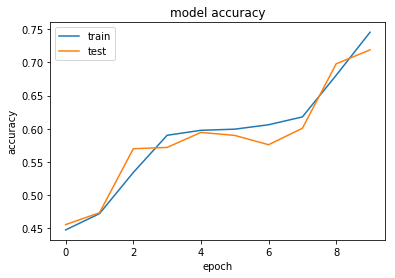

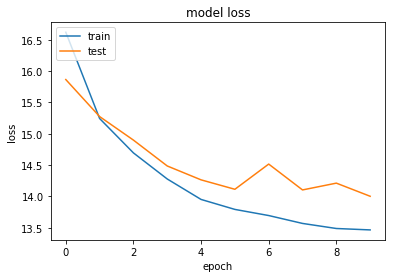

In [104]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

start
4/4 [==============================] - 14s 4s/step


/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


500/500 [==============================] - 12s 25ms/step
processed 499 images
road : 0.7613887447642579
sidewalk : 0.32197399065011595
building : 0.4028917927668732
wall : 0.0
fence : 0.0011334374729437856
pole : 0.0741472688372084
traffic light : 0.0
traffic sign : 0.00010409416581371546
vegetation : 0.04406455775355378
terrain : 0.02068582339000278
sky : 0.0
person : 0.048520464723993614
rider : 0.0003274151867848808
car : 0.4186760595683085
truck : 0.0
bus : 0.0
train : 0.0
motorcycle : 0.0
bicycle : 0.07113442822557083
0.13507798342861854


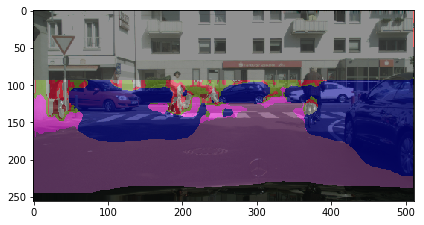

In [105]:
print('start')
SCALE = 4
def eval_model(model):                  
        x_pred = model.predict(x_val_data,verbose = 1)        
        new_x = np.argmax(x_pred,axis = 3)        
        new_x = new_x.astype(int)        
        y_val = np.argmax(y_val_data,axis = 3)
        score = eval_preds(new_x,y_val)        
        return score
    
model = load_model('unet_tensorflow.hdf5', custom_objects={'tversky_loss': tversky_loss})

x_pred = model.predict(x_val_data[0:4],verbose=1)  

pred_image=np.argmax(x_pred[2],axis=2).astype(int)
pred_image.shape
y_img = np.argmax(y_val_data[2],axis=2).astype(int)
y_img.shape
colorImage(x_val_data[2],pred_image, 'classes.txt', 'colors.txt')

print(eval_model(model))